<a href="https://colab.research.google.com/github/anabarrerar/AnaBarrera_Portfolio/blob/main/ICR%20-%20Identifying%20Age-Related%20Conditions/EDA_ICR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook requeriments


In [1]:
!pip install -q kaggle #kaggle
import os

def authenticate_kaggle(key_path):
    # Mount your Google Drive to Colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Copy the Kaggle API key from your Drive to the .kaggle directory in your Drive
    !mkdir -p /root/.kaggle
    !cp '{key_path}/kaggle.json' /root/.kaggle/

    # Set the permissions for the Kaggle API key
    !chmod 600 /root/.kaggle/kaggle.json

    # Authenticate with the Kaggle API
    os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"

    if os.environ.get('KAGGLE_CONFIG_DIR') == "/root/.kaggle":
        print('Authenticated with Kaggle API')

key_path = "/content/drive/MyDrive/Colab Notebooks"

authenticate_kaggle(key_path)

! kaggle competitions download -c icr-identify-age-related-conditions

!unzip icr-identify-age-related-conditions.zip

Mounted at /content/drive
Authenticated with Kaggle API
  0% 0.00/150k [00:00<?, ?B/s]
100% 150k/150k [00:00<00:00, 76.9MB/s]
Archive:  icr-identify-age-related-conditions.zip
  inflating: greeks.csv              
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [193]:
#Importing other packages
import timeit
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import missingno as msno
from datetime import datetime

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, log_loss


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Description

The goal of this project is to predict if a person has one or more of any of three medical conditions (Class 1), or none of the three medical conditions (Class 0).

To determine if someone has these medical conditions requires a long and intrusive process to collect information from patients. With predictive models, we can shorten this process and keep patient details private by collecting key characteristics relative to the conditions, then encoding these characteristics.

This project will help researchers discover the relationship between measurements of certain characteristics and potential patient conditions.

The competition data comprises over fifty anonymized health characteristics linked to three age-related conditions. Your goal is to predict whether a subject has or has not been diagnosed with one of these conditions -- a binary classification problem.



**train.csv - The training set** 617 rows, 58 columns
* `Id:` Unique identifier for each observation.
* `AB-GL:` Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical and binomial.
* `Class:` A binary target, 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.


**test.csv - The test set** The goal is to predict the probability that a subject in this set belongs to each of the two classes.


**greeks.csv - Supplemental metadata**, only available for the training set. 617 rows, 6 columns
* `Alpha:` Identifies the type of age-related condition, if present.

    A: No age-related condition. Corresponds to class 0.

    B, D, G: The three age-related conditions. Correspond to class 1.

* `Beta, Gamma, Delta:` Three experimental characteristics.
* `Epsilon:`The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

In [371]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
greeks =pd.read_csv('greeks.csv')
sample_sub=pd.read_csv('sample_submission.csv')

# Data Understanding (EDA)

## Train dataset

In [372]:
print(train.shape)
print('Duplicated rows:',train.duplicated().any())
train.head()

(617, 58)
Duplicated rows: False


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


* Only feature `EJ` is categorical
* No duplicated rows

In [373]:
print(train['Class'].value_counts() / len(train) * 100)

0    82.495948
1    17.504052
Name: Class, dtype: float64


In [374]:
train['Class'].value_counts()

0    509
1    108
Name: Class, dtype: int64

**The data has a class imbalance:**

* Class 0 represent 82.5% of the data (509 records)
* Class 1 represent 17.5% of the data (108 records)

In [375]:
print('Percentage of missing values:\n',((train.isnull().sum()[train.isnull().sum()>0]) / len(train)) * 100)

Percentage of missing values:
 BQ    9.724473
CB    0.324149
CC    0.486224
DU    0.162075
EL    9.724473
FC    0.162075
FL    0.162075
FS    0.324149
GL    0.162075
dtype: float64


The missing values, seem to have a pattern, let's understand the distribution of missing values in the train set.

<Axes: >

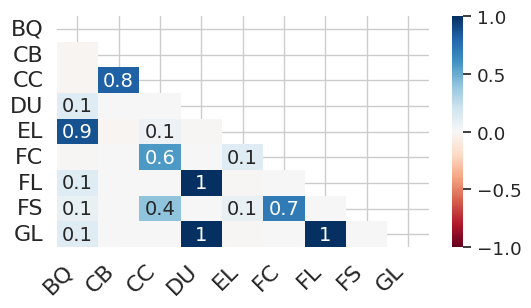

In [376]:
# Plot the correlation between missing values
fig, ax = plt.subplots(figsize=(6, 3))
msno.heatmap(train, ax=ax)

* Missing values in `BQ `are highly correlated with `EL`, it means their are not the same but almost
* Missing values in `CB` are highly correlated with `CC`
* Missing values in `CC` are correlated with `FC` and `FS` (and FC with FS)
* Missing values in `DU` are the same that in `FL` and `GL`

This means that the missing values in these columns are not randomly distributed, but rather they tend to occur together. The fact that these missing values are correlated suggests that there may be a common reason why they are missing. For example, all of the columns with correlated missing values may be related to a particular feature of the data that is difficult to collect.

### Visualization

In [377]:
train_original=train.copy()
first_category = train.EJ.unique()[0]
train.EJ = train.EJ.eq(first_category).astype('int')
test.EJ = test.EJ.eq(first_category).astype('int')
target_col = 'Class'
data = pd.concat([train, greeks], axis=1)

In [34]:
def plot_distribution(train):
    num_cols = 4
    num_rows = (len(train.columns) - 1) // num_cols  # Subtract 1 to exclude the first column
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 3*num_rows))
    sns.set(font_scale=1.2, style='whitegrid')

    col_names = train.columns[1:]  # Exclude the first column
    for i, col_name in enumerate(col_names):
        if col_name != 'Class':
            ax = axes[i // num_cols, i % num_cols]
            sns.kdeplot(data=train, x=col_name, hue='Class', ax=ax, fill=True, alpha=0.5, linewidth=2)

            ax.set_title(f'{col_name.title()} Distribution by Class', fontsize=14)
            ax.set_xlabel(col_name.title(), fontsize=10)
            #ax.set_ylabel('Class', fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.legend([1, 0], title='Class', fontsize=8)
            ax.grid(False)

    plt.tight_layout()
    plt.show()

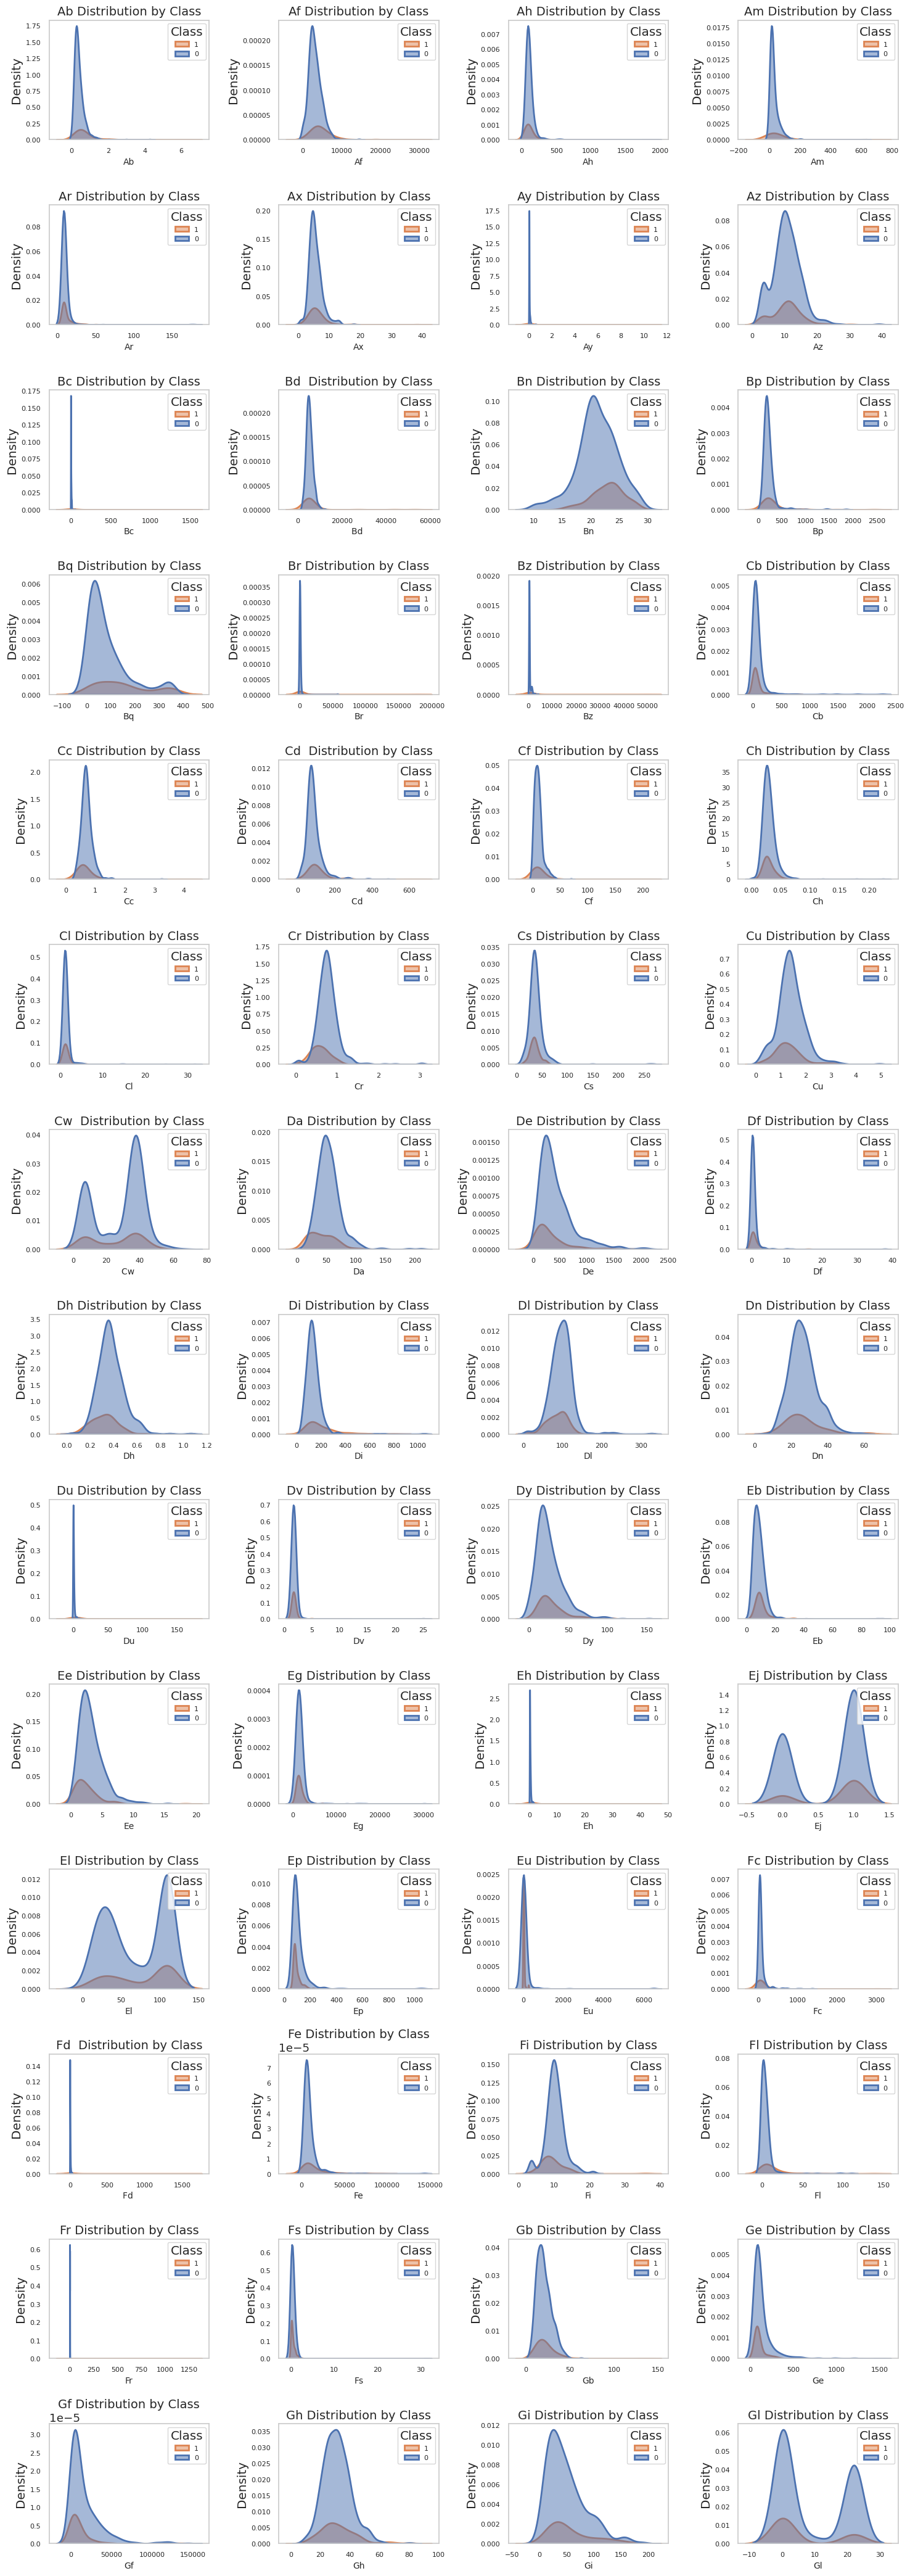

In [35]:
plot_distribution(train)

In [398]:
train.groupby(by='Class')[['AY','BC','BR','BZ','DU','EH','FD ', 'FR']].mean().T

Class,0,1
AY,0.044508,0.134840
BC,3.377568,30.088202
BR,909.383730,2673.258234
BZ,443.193485,1056.988744
DU,0.716517,6.912927
EH,0.152172,1.025886
FD,3.022843,25.344778
FR,1.129568,14.865456


We can see one of two different cases in variables:

* There are values ​​mostly associated with a certain class, as in the case of: `AY`,`BC`,`BR`,`BZ`,`DU`,`EH`,`FD`, `FR`...

* The distribution of values ​​overlaps between classes, which means that instances of different classes share similar characteristics, making it difficult to distinguish them clearly and precisely.

When there is class overlap, the decision boundaries between classes become less clear cut and it is more difficult for a classification model to learn and correctly assign instances to their corresponding categories.
When there is class overlap, the decision boundaries between classes become less clear and it is more difficult for a classification model to learn and correctly assign instances to their corresponding categories.

>  **EJ:**


In [380]:
train_ej_a=train_original[train_original['EJ']=='A']
train_ej_b=train_original[train_original['EJ']=='B']

In [80]:
def constant_features(df):
    unique_values = df.iloc[:, 1:].nunique()
    features = unique_values[unique_values == 1].index.tolist() # Select features with only one unique value

    return features

print(constant_features(train_ej_a))
print(constant_features(train_ej_b))

['DU', 'EH', 'EJ', 'FD ', 'FL', 'GL']
['EJ']


In [394]:
train_ej_a[['DU', 'EH', 'FD ', 'FL', 'GL']].head(1)

,DU,EH,FD,FL,GL
1,0.005518,0.003042,0.29685,0.173229,21.978


The categorical variable "EJ" serves as a segmentation for the data, and it is associated with constant values from certain variables.

### Correlation Matrix

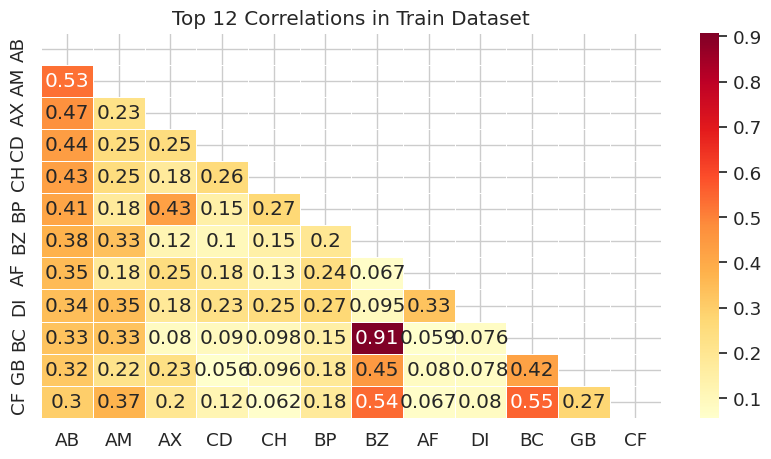

In [83]:
def plot_top_correlations(df: pd.core.frame.DataFrame, n: int, title_name: str='Top Correlations') -> None:
    # Calculate correlation between all variables
    corr = df.corr()

    # Select variables having highest absolute correlation
    top_corr_cols = corr.abs().nlargest(n, columns=corr.columns).index
    top_corr = corr.loc[top_corr_cols, top_corr_cols]

    fig, axes = plt.subplots(figsize=(10, 5))
    mask = np.zeros_like(top_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(top_corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# Plot heatmap of top 12 correlations in training data
plot_top_correlations(train, 12, 'Top 12 Correlations in Train Dataset')

Among the top-12 highly correlated numerical variables, although certain variables exhibit strong correlations, the overall correlation among the variables is not very high. This is especially considering that all the variables are health-related data.

## Greeks Dataset

In [272]:
greeks_original=greeks.copy()
print(greeks.shape)
print('Duplicated rows:',greeks.duplicated().any())
print('Missing values:',greeks.isna().sum().any())
greeks.head()

(617, 6)
Duplicated rows: False
Missing values: False


,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


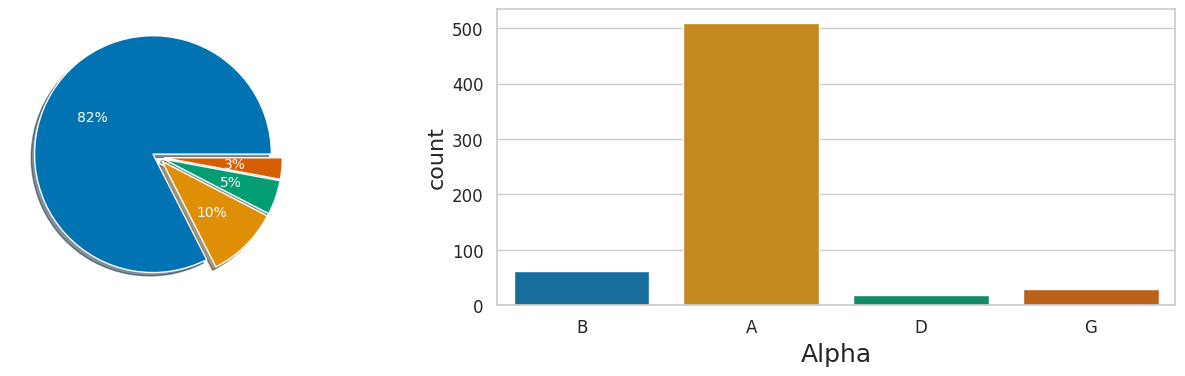

In [183]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
ax = ax.flatten()

# Pie chart
ax[0].pie(greeks['Alpha'].value_counts(), shadow=True, explode=[0.05] * len(greeks['Alpha'].unique()),
        autopct='%1.f%%',textprops={'size': 10, 'color': 'white'},
          colors=sns.color_palette('colorblind', len(greeks['Alpha'].unique())))

# Bar plot
sns.countplot(data=greeks, x='Alpha', ax=ax[1], palette='colorblind')
ax[1].yaxis.label.set_size(16)
plt.yticks(fontsize=12)
ax[1].set_xlabel('Alpha', fontsize=18)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

In [273]:
greeks_=pd.merge(greeks, train[['Id', 'Class']], on='Id', how='left')
greeks_.groupby(by='Alpha')['Class'].value_counts()

Alpha  Class
A      0        509
B      1         61
D      1         18
G      1         29
Name: Class, dtype: int64

In [ ]:
greeks.Epsilon=greeks_[greeks_.Epsilon=='Unknown']

**Alpha:**
* 82% of the records (509 patients) have no condition, that is, they are class 0.* The most common condition in the data is `B`, followed by `G` and `D` with 10%, 5% and 3% respectively

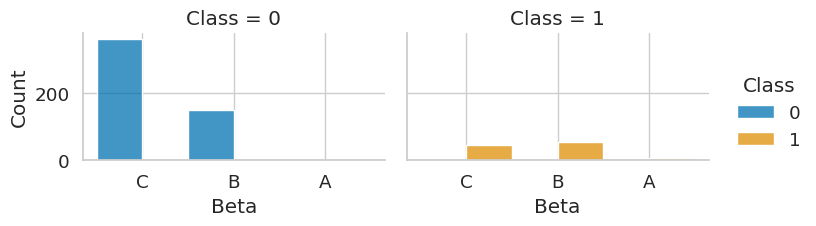

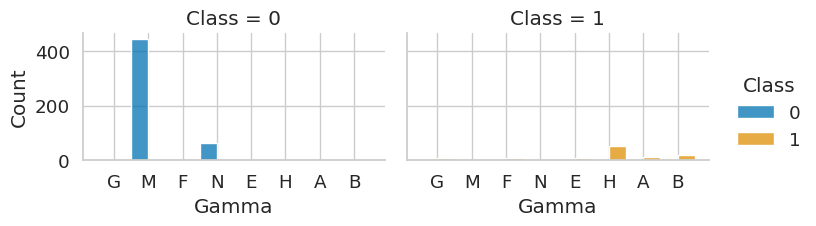

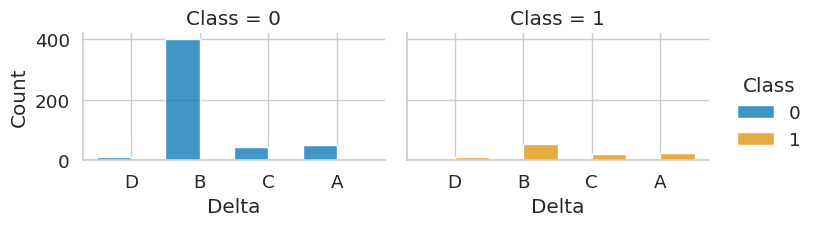

In [189]:
sns.displot(greeks_, x="Beta",hue="Class",height=2.5, aspect=1.5,col="Class",palette='colorblind',multiple="dodge")
sns.displot(greeks_, x="Gamma",hue="Class", height=2.5, aspect=1.5,col="Class",palette='colorblind',multiple="dodge")
sns.displot(greeks_, x="Delta",hue="Class", height=2.5, aspect=1.5,col="Class",palette='colorblind',multiple="dodge")

**Beta:** Patients with ` A `have a condition.

**Gamma:** Patients with `M` and `N` doesn't have a condition.

**Delta:** Delta categories are distributed similarly for patients with and without a condition.

**EPSILON:**

In [275]:
greeks_['Epsilon'] = greeks_['Epsilon'].replace({'Unknown': np.nan})
greeks_['Epsilon'] = pd.to_datetime(greeks_['Epsilon'])
greeks_['year'] = greeks_['Epsilon'].dt.year
greeks_['month'] = greeks_['Epsilon'].dt.month
greeks_['day']=greeks_['Epsilon'].dt.day

In [302]:
print('First date record',greeks_['Epsilon'].min())
print('Last date record',greeks_['Epsilon'].max())

First date record 2012-05-17 00:00:00
Last date record 2020-09-29 00:00:00


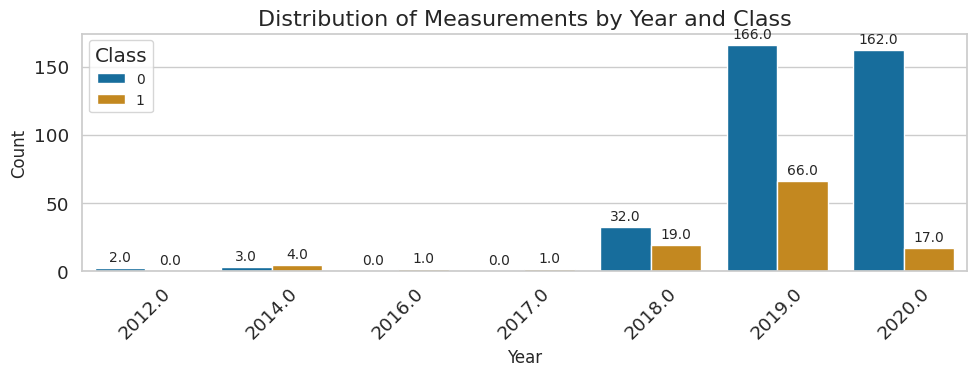

In [303]:
plt.figure(figsize=(10, 4))
ax = sns.countplot(data=greeks_, x='year', hue='Class', palette='colorblind')

# Add the count above each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5, height, ha="center", fontsize=10)

plt.title('Distribution of Measurements by Year and Class', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Class', fontsize=10)
plt.tight_layout()
plt.show()

In [329]:
greeks_['date']=greeks_['Epsilon'].apply(lambda x: 'missing' if pd.isna(x) else 'not missing')
greeks_.groupby(by='Class')['date'].value_counts()

Class  date       
0      not missing    365
       missing        144
1      not missing    108
Name: date, dtype: int64

Here we see that most of the dated observations occur in 2019-2020 and that all the missing dates are related to class 0. We can think that these results were considered less important and were not dated.

Are these missing values ​​related to the missing values ​​in the training data set?

<Axes: >

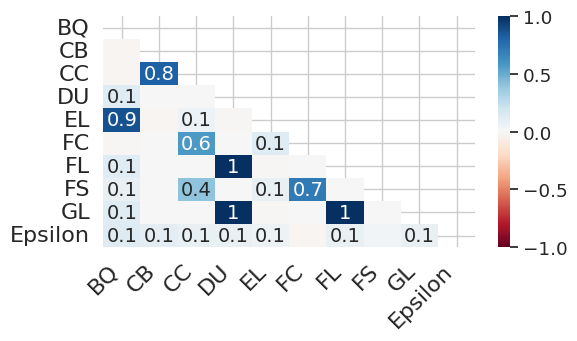

In [340]:
train_=pd.merge(train,greeks[['Id','Epsilon']],on='Id', how='left')
train_['Epsilon']=train_['Epsilon'].replace({'Unknown': np.nan})

# Plot the correlation between missing values
fig, ax = plt.subplots(figsize=(6, 3))
msno.heatmap(train_, ax=ax)

We cannot assume that the data is related

Key points for modelling:
* The binary target is not balanced
* Missing values seems to have a pattern
* Due to the variety of ranges we have to transform the data
* Missing values in Epsilon are related to class 0.